### Q: How do neutral codon probabilities compare to empirical ones?

* How does the answer depend on branch lengths?
* How do multinucleotide codon probabilities compare?

**Terminology**: the _hit class_ of a codon mutation describes the number of differences from the parent codon. E.g. `AAA -> ACT` has hit class 2. I use this terminology to avoid overloaded terms like "number of differences" which gets confusing when we are talking about number of overall differences from parent.

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES

from epam import molevol, sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices
from pathlib import Path


from shmex.shm_data import load_shmoof_dataframes, pcp_df_of_non_shmoof_nickname, dataset_dict
from shmex.shm_eval import oe_plot_of, optimized_branch_lengths_of_crepe
from shmex.multihit import (
    codon_probs_of_parent_scaled_nt_rates_and_sub_probs,
    prepare_pcp_df,
    trim_seqs_to_codon_boundary_and_max_len,
    hit_class,
    hit_class_probs,
    hit_class_probs_seq,
    hit_classes_of_pcp_df,
    branch_length_quantile_dict_of_pcp_df,
    hc_site_df_of_pcp_df,
    mmatch_2,
    mmatch_3,
    simple_codon_oe_plot,
)

Using CPU


In [3]:
Path('_ignore').mkdir(exist_ok=True)

In [4]:
site_count = 500
crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
crepe = framework.load_crepe(crepe_path)
model = crepe.model

We're just going to use shmoof training data, the same data used to train the context NT model.

In [5]:
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df["branch_length"] = pd.read_csv(crepe_path+".train_branch_lengths.csv")["branch_length"]
pcp_df = train_df
pcp_df

,sample_id,family,parent,child,branch_length,v_gene,child_is_leaf,nickname
0,316188,1810,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.006826,IGHV4-MIXED,True,88
1,316188,1810,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.013652,IGHV4-MIXED,True,88
2,316188,1810,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.006826,IGHV4-MIXED,True,88
3,316188,1810,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.003413,IGHV4-MIXED,True,88
4,316188,1810,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.003413,IGHV4-MIXED,True,88
...,...,...,...,...,...,...,...,...
46386,326713,7218,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.034483,IGHV3-74*03,False,13
46387,326713,7218,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.003448,IGHV3-74*03,True,13
46388,326713,7218,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.006897,IGHV3-74*03,True,13
46389,326713,7218,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.006897,IGHV3-74*03,True,13


In [6]:
tang_df = pcp_df_of_non_shmoof_nickname("tangshm")
subsampled_tang_df = tang_df.iloc[::int(len(tang_df)/4000)].copy().reset_index(drop=True)
subsampled_tang_df["branch_length"] = optimized_branch_lengths_of_crepe(crepe, subsampled_tang_df)

# take the first 1000 row
# pcp_df = pcp_df[:1000].copy()

Loading /Users/wdumm/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz


/Users/wdumm/opt/miniconda3/envs/epam/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Finding optimal branch lengths: 100%|██████████| 4992/4992 [01:57<00:00, 42.37it/s]


In [28]:
tang_df

,sample_id,family,parent_name,parent,child_name,child,branch_length,depth,distance,v_gene,cdr1_codon_start,cdr1_codon_end,cdr2_codon_start,cdr2_codon_end,cdr3_codon_start,cdr3_codon_end,parent_is_naive,child_is_leaf
0,B21,20627,naive,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,Node1,GAGGTGTCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCTGGGG...,0.094299,1,0.094299,IGHV3-23*01,75,96,150,171,288,338,True,False
1,B21,20627,Node1,GAGGTGTCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCTGGGG...,14468209,GAGGTGTCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCGGGGG...,0.024790,2,0.119089,IGHV3-23*01,75,96,150,171,288,338,False,True
2,B21,20627,Node1,GAGGTGTCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCTGGGG...,14442084,GAGGTGGCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCTGGGG...,0.015583,2,0.109881,IGHV3-23*01,75,96,150,171,288,338,False,True
3,B21,25204,naive,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,Node1,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,0.044305,1,0.044305,IGHV4-59*01,75,96,150,168,285,343,True,False
4,B21,25204,Node1,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,14472984,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,0.002647,2,0.046952,IGHV4-59*01,75,96,150,168,285,343,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,AG476,2288,naive,GAAGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCA...,Node1,GAAGTGCAGTTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCA...,0.084466,1,0.084466,IGHV3-9*01,75,96,150,171,288,341,True,False
9980,AG476,2288,Node1,GAAGTGCAGTTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCA...,12846308,GAGGTGCAGTTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCA...,0.002651,2,0.087117,IGHV3-9*01,75,96,150,171,288,341,False,True
9981,AG476,1701,Node1,CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGT...,12866725,CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGT...,0.002722,2,0.002723,IGHV1-69*01,75,96,150,171,288,332,False,True
9982,AG476,736,naive,CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGT...,Node1,CAGGTCCAACTGGTGCATTCTGGGGCTGAGGTGAGGAAGGCTGACT...,0.165673,1,0.165673,IGHV1-69*01,75,96,150,171,288,322,True,False


In [7]:
pcp_df = subsampled_tang_df

In [29]:
pcp_df = prepare_pcp_df(pcp_df, crepe, site_count)
assert pcp_df["parent"].apply(len).max() <= site_count - site_count % 3
pcp_df


,sample_id,family,parent_name,parent,child_name,child,branch_length,depth,distance,v_gene,cdr1_codon_start,cdr1_codon_end,cdr2_codon_start,cdr2_codon_end,cdr3_codon_start,cdr3_codon_end,parent_is_naive,child_is_leaf,rates,subs_probs
0,B21,20627,naive,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,Node1,GAGGTGTCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCTGGGG...,0.087465,1,0.094299,IGHV3-23*01,75,96,150,171,288,338,True,False,"[tensor(0.3735), tensor(0.9317), tensor(0.8590...","[[tensor(0.3171), tensor(0.4790), tensor(0.), ..."
1,B21,20627,Node1,GAGGTGTCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCTGGGG...,14442084,GAGGTGGCGATGTTGGAGTCTGGGGGAGACTTGGTACCGCCTGGGG...,0.021223,2,0.109881,IGHV3-23*01,75,96,150,171,288,338,False,True,"[tensor(0.4385), tensor(0.5819), tensor(1.0424...","[[tensor(0.2840), tensor(0.4552), tensor(0.), ..."
2,B21,25204,Node1,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,14472984,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,0.003082,2,0.046952,IGHV4-59*01,75,96,150,168,285,343,False,True,"[tensor(0.2646), tensor(0.8167), tensor(0.9016...","[[tensor(0.3535), tensor(0.), tensor(0.2790), ..."
3,B21,608,Node1,CAGGTGCTGCTCCAGCAGTGGGGCGCAGGACTGTTGAAGCCTTCGG...,14444430,CAGGTGCTGCTCCAGCAGTGGGGCGCAGGACTGTTGAAGCCTTCGG...,0.007443,2,0.071525,IGHV4-34*01,75,96,150,168,285,307,False,True,"[tensor(0.2646), tensor(0.8391), tensor(0.6287...","[[tensor(0.3535), tensor(0.), tensor(0.2790), ..."
4,B21,27384,naive,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTGGTCCAGCCTGGGG...,Node1,GAGGTGCAATTGGTGGACTCTGGGGGAGGCTTGGTCCAACCTGGGG...,0.085561,1,0.075854,IGHV3-73*02,75,96,150,177,294,370,True,False,"[tensor(0.3735), tensor(0.9317), tensor(0.8590...","[[tensor(0.3171), tensor(0.4790), tensor(0.), ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,AG445,3443,Node1,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,12758061,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,0.023897,2,0.051439,IGHV3-64*01,75,96,150,171,288,322,False,True,"[tensor(0.3735), tensor(0.9317), tensor(0.8590...","[[tensor(0.3171), tensor(0.4790), tensor(0.), ..."
4988,AG476,1929,Node1,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,12822719,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,0.165679,2,0.148925,IGHV3-30*18,75,96,150,171,288,335,False,True,"[tensor(0.2646), tensor(0.8167), tensor(0.9016...","[[tensor(0.3535), tensor(0.), tensor(0.2790), ..."
4989,AG476,731,Node1,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,12831035,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,0.009603,2,0.025549,IGHV3-30*18,75,96,150,171,288,322,False,True,"[tensor(0.2646), tensor(0.8167), tensor(0.9016...","[[tensor(0.3535), tensor(0.), tensor(0.2790), ..."
4990,AG476,2288,Node1,GAAGTGCAGTTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCA...,12846308,GAGGTGCAGTTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCA...,0.003117,2,0.087117,IGHV3-9*01,75,96,150,171,288,341,False,True,"[tensor(0.6802), tensor(1.0170), tensor(1.3223...","[[tensor(0.3411), tensor(0.3877), tensor(0.), ..."


#### Now let's move on to the codon-level process

The following sets us up to work with "hit classes", which are the number of differences within a codon as described above. That is, we're calculating the probability of $x$ mutations within a codon given the model.

In [9]:
# This block just sets up `hit_class_tensors`, a dictionary of tensors that we can use to compute the number of differences between codons, as well as `codon_to_idxs` which maps codons to their indices in the tensors.


# Initialize a dictionary to store hit_class_tensors indexed by codons
hit_class_tensors = {}

# Iterate over all possible codons and calculate the hit_class_tensors
for i, base1 in enumerate(BASES):
    for j, base2 in enumerate(BASES):
        for k, base3 in enumerate(BASES):
            codon = base1 + base2 + base3
            hit_class_tensor = torch.zeros(4, 4, 4, dtype=torch.int)
            for i2, base1_2 in enumerate(BASES):
                for j2, base2_2 in enumerate(BASES):
                    for k2, base3_2 in enumerate(BASES):
                        codon_2 = base1_2 + base2_2 + base3_2
                        hit_class_tensor[i2, j2, k2] = hit_class(codon, codon_2)
            hit_class_tensors[codon] = hit_class_tensor

# make a dict mapping from codon to triple integer index
codon_to_idxs = {base_1+base_2+base_3: (i, j, k) for i, base_1 in enumerate(BASES) for j, base_2 in enumerate(BASES) for k, base_3 in enumerate(BASES)}
codon_to_idxs

ctc_hit_class_tensor = hit_class_tensors["CTC"]
assert ctc_hit_class_tensor[codon_to_idxs["CTC"]] == 0
assert ctc_hit_class_tensor[codon_to_idxs["ATC"]] == 1
assert ctc_hit_class_tensor[codon_to_idxs["ACC"]] == 2
assert ctc_hit_class_tensor[codon_to_idxs["ACT"]] == 3

Now we need to prepare dataframes for the codon-level OE plot.

In [10]:
# This block just shows how things are going to go for a single parent sequence.

parent, rates, subs_probs, branch_length = pcp_df.loc[0, ["parent", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_nt_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[8.2460e-01, 1.6441e-01, 1.0760e-02, 2.3185e-04],
        [8.8661e-01, 1.0931e-01, 4.0309e-03, 4.3584e-05],
        [8.3633e-01, 1.5408e-01, 9.4042e-03, 1.9004e-04],
        [9.1653e-01, 8.1119e-02, 2.3304e-03, 2.1615e-05],
        [8.4581e-01, 1.4647e-01, 7.5949e-03, 1.2357e-04],
        [9.3861e-01, 6.0169e-02, 1.2162e-03, 7.5121e-06]])

In [11]:

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
example_hit_classes = hit_classes_of_pcp_df(example_df, 4)
example_hit_classes

tensor([[   0,    0,    1, -100],
        [   0,    0,    1,    2]])

In [12]:
branch_length_quantile_dict = branch_length_quantile_dict_of_pcp_df(pcp_df)
branch_length_quantile_dict

{0: 3,
 1: 1,
 2: 0,
 3: 1,
 4: 3,
 5: 2,
 6: 1,
 7: 1,
 8: 0,
 9: 0,
 10: 0,
 11: 2,
 12: 3,
 13: 2,
 14: 1,
 15: 1,
 16: 1,
 17: 3,
 18: 2,
 19: 2,
 20: 2,
 21: 3,
 22: 2,
 23: 2,
 24: 2,
 25: 2,
 26: 0,
 27: 1,
 28: 0,
 29: 0,
 30: 3,
 31: 0,
 32: 2,
 33: 1,
 34: 3,
 35: 0,
 36: 1,
 37: 2,
 38: 3,
 39: 3,
 40: 1,
 41: 0,
 42: 0,
 43: 1,
 44: 3,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 3,
 51: 0,
 52: 1,
 53: 1,
 54: 2,
 55: 1,
 56: 0,
 57: 3,
 58: 1,
 59: 1,
 60: 2,
 61: 3,
 62: 1,
 63: 3,
 64: 2,
 65: 3,
 66: 3,
 67: 0,
 68: 3,
 69: 2,
 70: 3,
 71: 2,
 72: 0,
 73: 1,
 74: 2,
 75: 2,
 76: 1,
 77: 1,
 78: 1,
 79: 3,
 80: 3,
 81: 3,
 82: 0,
 83: 3,
 84: 2,
 85: 3,
 86: 2,
 87: 1,
 88: 2,
 89: 3,
 90: 1,
 91: 1,
 92: 1,
 93: 0,
 94: 1,
 95: 3,
 96: 3,
 97: 3,
 98: 2,
 99: 2,
 100: 2,
 101: 3,
 102: 1,
 103: 0,
 104: 3,
 105: 1,
 106: 2,
 107: 3,
 108: 3,
 109: 0,
 110: 0,
 111: 0,
 112: 3,
 113: 0,
 114: 1,
 115: 3,
 116: 0,
 117: 3,
 118: 1,
 119: 1,
 120: 3,
 121: 1,
 122: 0,
 12

In [13]:

hc_site_df = hc_site_df_of_pcp_df(pcp_df, hit_class_tensors, site_count, branch_length_quantile_dict)
hc_site_df

Consolidating rows: 100%|██████████| 4992/4992 [00:06<00:00, 714.67it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,0,0,0.827547,0.162312,0.009960,0.000182,3
1,0,1,0,0.817734,0.170452,0.011560,0.000254,3
2,0,2,2,0.604516,0.344797,0.048662,0.002025,3
3,0,3,1,0.705822,0.262043,0.030966,0.001169,3
4,0,4,0,0.767138,0.213520,0.018833,0.000510,3
...,...,...,...,...,...,...,...,...
610483,4991,114,0,0.788302,0.195261,0.016003,0.000434,3
610484,4991,115,0,0.730612,0.244148,0.024579,0.000661,3
610485,4991,116,0,0.765943,0.213991,0.019485,0.000581,3
610486,4991,117,0,0.839995,0.151226,0.008628,0.000152,3


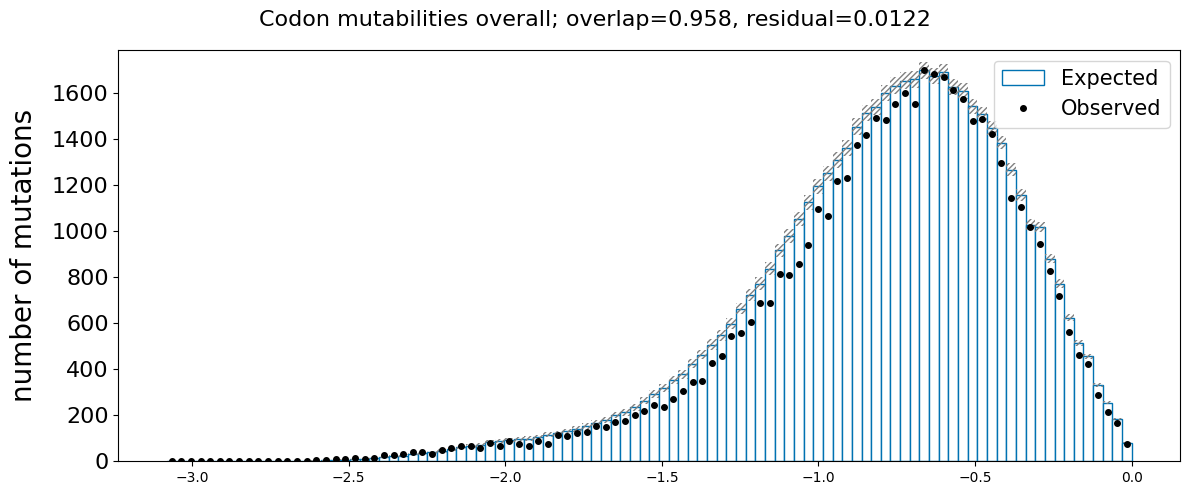

In [14]:
fig, result_dict = simple_codon_oe_plot(hc_site_df, "Codon mutabilities overall")

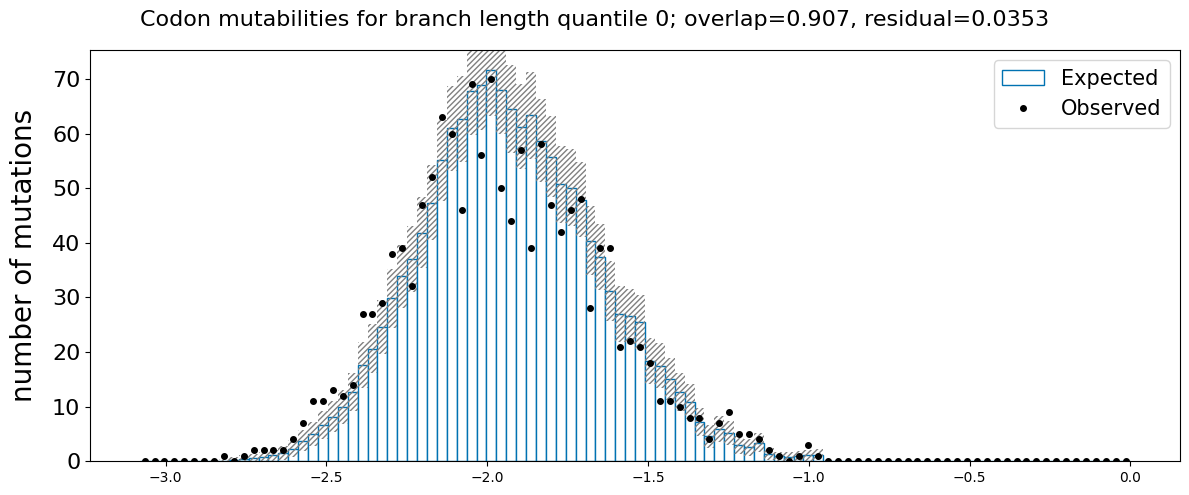

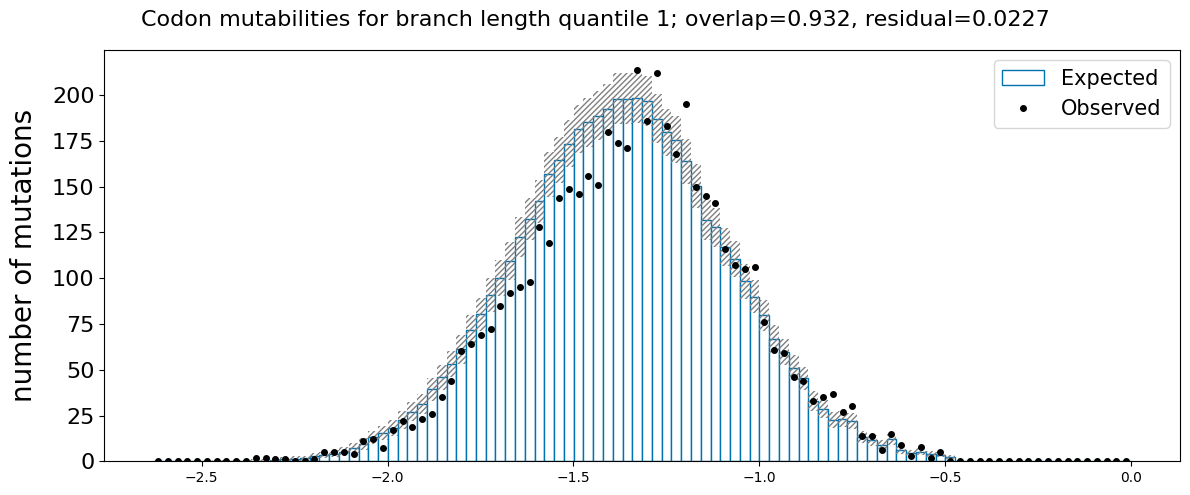

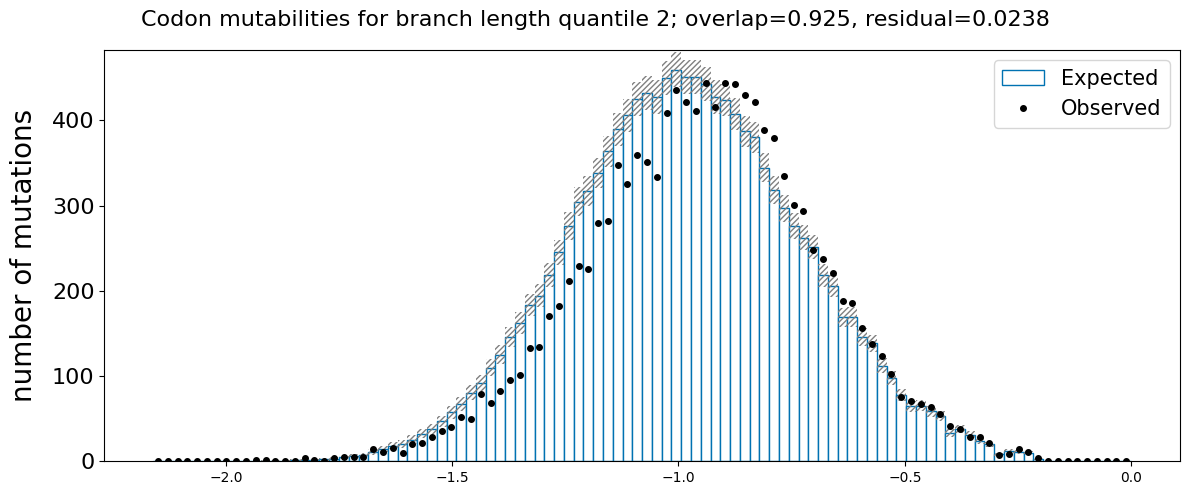

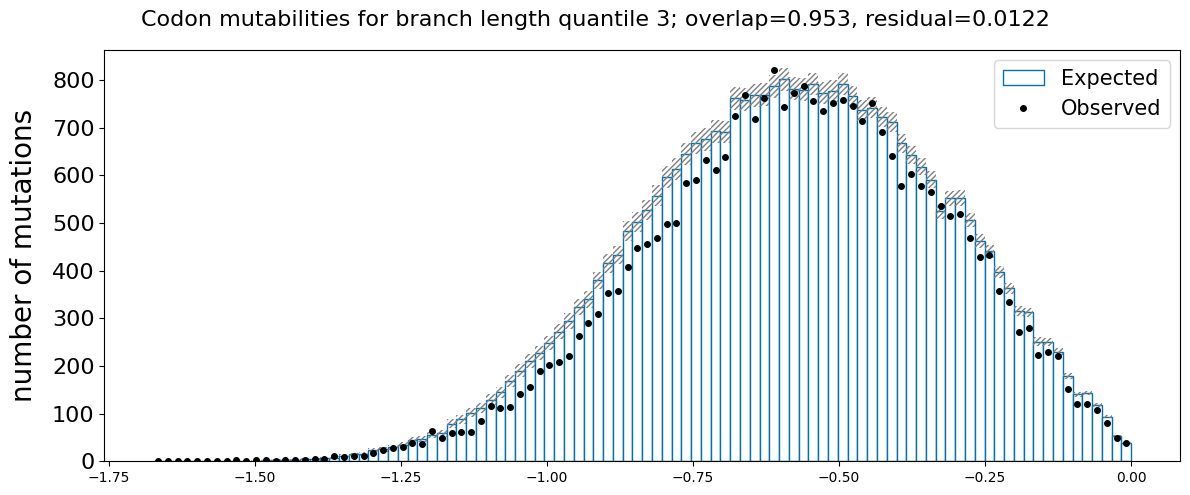

In [15]:
# loop over a groupby of pcp_df["branch_length_quantile"]
figs = []
results = []
for quantile, group in hc_site_df.groupby("branch_length_quantile"):
    fig, result = simple_codon_oe_plot(group, f"Codon mutabilities for branch length quantile {quantile}")
    figs.append(fig)
    results.append(result)

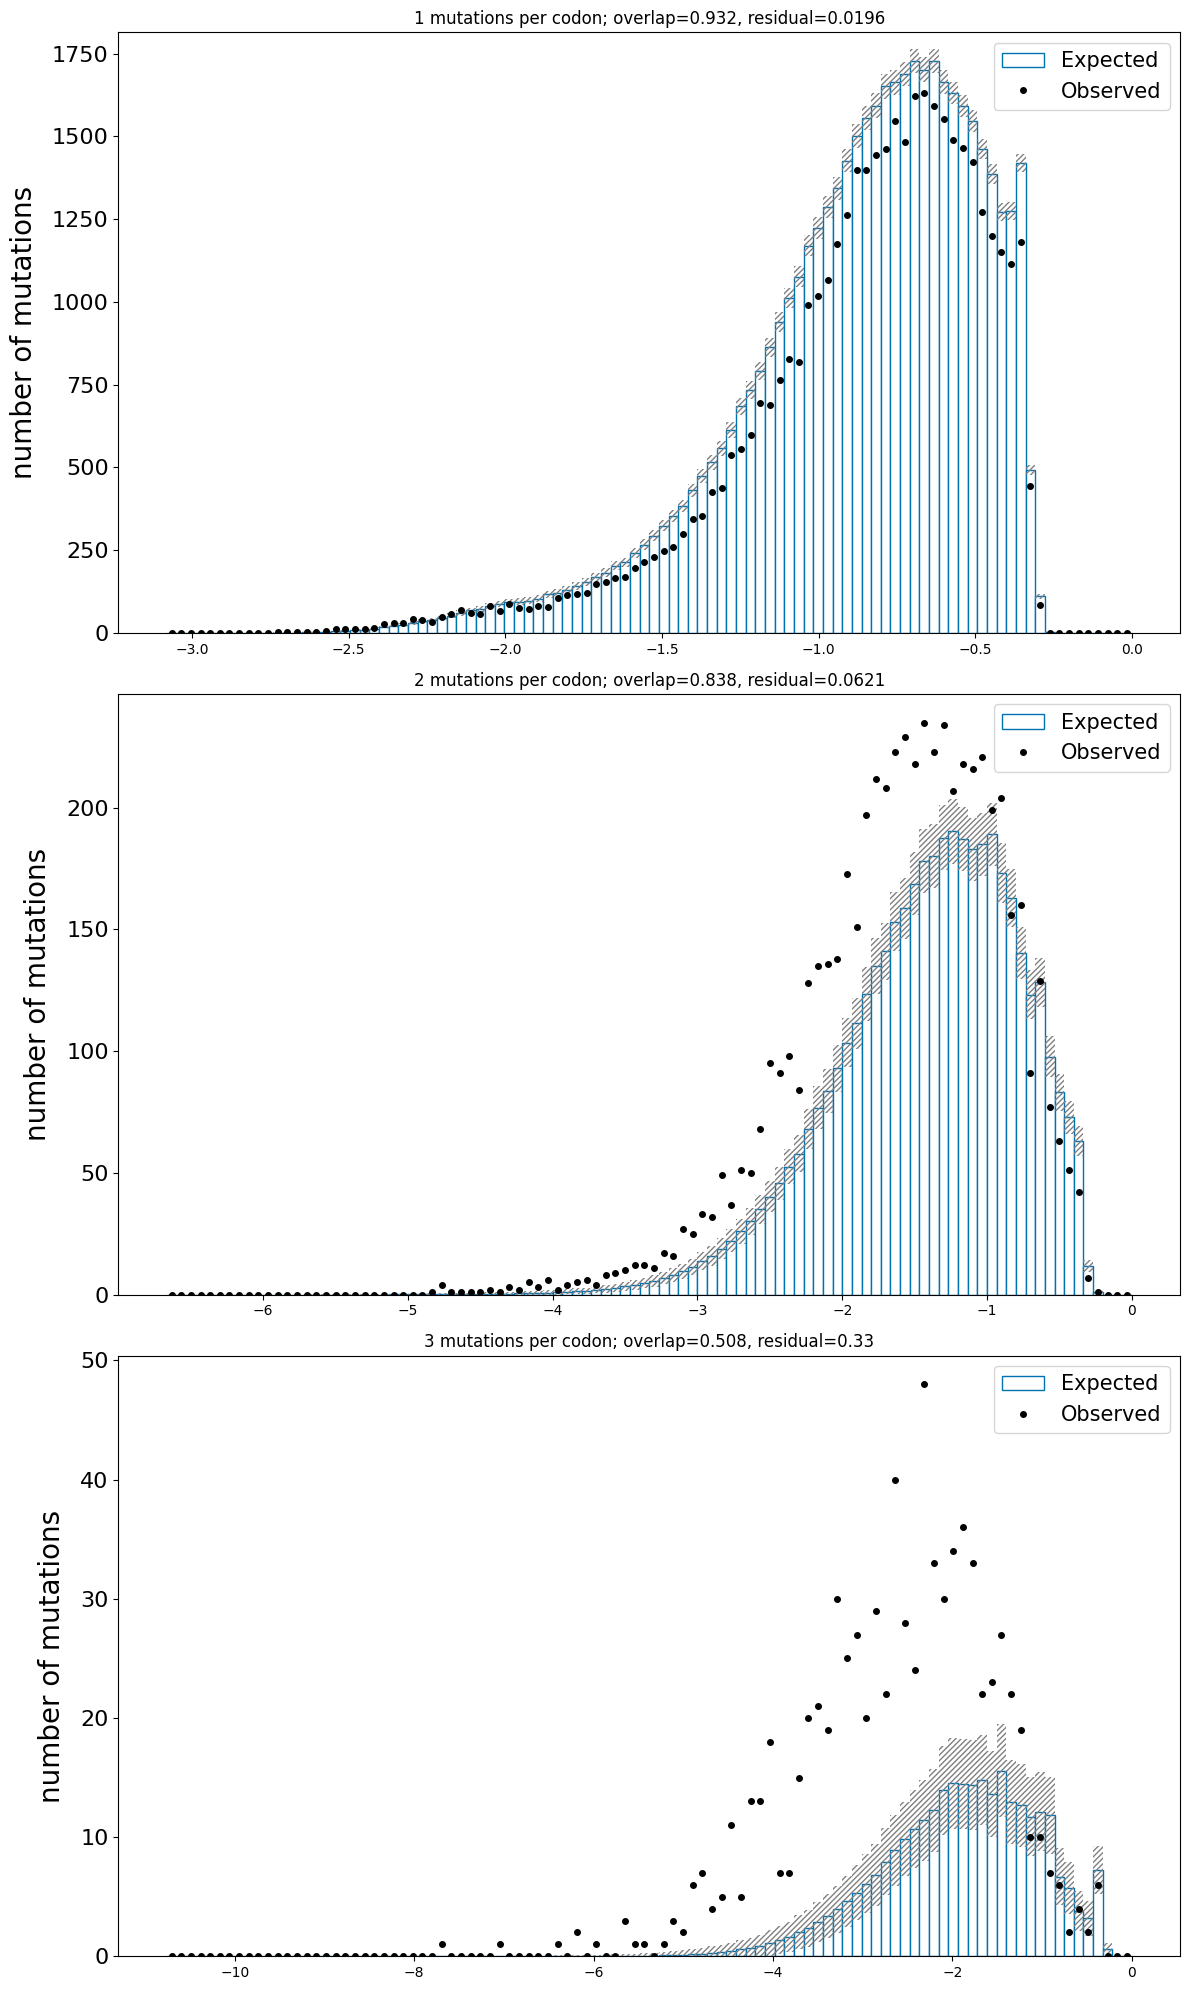

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(12, 20))

for i in range(3):
    hit_class = i + 1
    plot_df = pd.DataFrame({
        "mutation": hc_site_df["hit_class"] == hit_class,
        "prob": hc_site_df[f"{hit_class}_hc_prob"],
    })
    
    result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs[i], None)
    axs[i].set_title(f"{hit_class} mutations per codon; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
fig.tight_layout()
fig.savefig(f"_ignore/obs_vs_exp_mutations_per_codon.png")

### Let's look in detail about probabilities in terms of branch length

In [17]:
# select rows of pre_obs_vs_exp_df such that hit_class > 1
multihit_df = hc_site_df[hc_site_df["hit_class"] > 1].copy()
multihit_df["nt_site"] = multihit_df["site"] * 3
multihit_df

,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile,nt_site
2,0,2,2,0.604516,0.344797,0.048662,0.002025,3,6
42,0,42,2,0.868163,0.126193,0.005574,0.000070,3,126
52,0,52,2,0.485277,0.400144,0.105662,0.008917,3,156
56,0,56,2,0.354071,0.446377,0.177018,0.022534,3,168
546,4,56,2,0.599715,0.341820,0.055671,0.002794,3,168
...,...,...,...,...,...,...,...,...,...
610423,4991,54,2,0.558693,0.360441,0.075692,0.005173,3,162
610424,4991,55,2,0.427295,0.426386,0.133108,0.013211,3,165
610425,4991,56,2,0.573138,0.353082,0.069373,0.004407,3,168
610438,4991,69,2,0.627477,0.319137,0.050948,0.002438,3,207


In [18]:
# This block just shows things working for a single parent sequence.

parent, child, rates, subs_probs, branch_length = pcp_df.loc[14, ["parent", "child", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_nt_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

# hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[[2.1321e-07, 1.1554e-07, 2.2233e-04, 1.3453e-07],
         [8.7917e-11, 4.7644e-11, 9.1678e-08, 5.5474e-11],
         [2.1953e-10, 1.1897e-10, 2.2892e-07, 1.3852e-10],
         [1.4411e-10, 7.8095e-11, 1.5027e-07, 9.0930e-11]],

        [[9.5417e-04, 5.1708e-04, 9.9499e-01, 6.0207e-04],
         [3.9345e-07, 2.1322e-07, 4.1028e-04, 2.4826e-07],
         [9.8245e-07, 5.3241e-07, 1.0245e-03, 6.1991e-07],
         [6.4492e-07, 3.4950e-07, 6.7251e-04, 4.0694e-07]],

        [[2.4874e-07, 1.3480e-07, 2.5938e-04, 1.5695e-07],
         [1.0257e-10, 5.5583e-11, 1.0695e-07, 6.4718e-11],
         [2.5611e-10, 1.3879e-10, 2.6706e-07, 1.6160e-10],
         [1.6812e-10, 9.1108e-11, 1.7531e-07, 1.0608e-10]],

        [[3.2298e-07, 1.7503e-07, 3.3680e-04, 2.0380e-07],
         [1.3318e-10, 7.2173e-11, 1.3888e-07, 8.4035e-11],
         [3.3255e-10, 1.8022e-10, 3.4678e-07, 2.0983e-10],
         [2.1830e-10, 1.1830e-10, 2.2764e-07, 1.3775e-10]]])

In [19]:
valid_length = (len(parent) // 3) * 3

# Chunk into codons and count mutations
mutations = []
for i in range(0, valid_length, 3):
    parent_codon = parent[i:i+3]
    child_codon = child[i:i+3]
    
    if parent_codon != child_codon:
        mutations.append((i, parent_codon, child_codon, codon_to_idxs[child_codon]))

multihit_sites = set([201, 246])
multihit_mutations = [m for m in mutations if m[0] in multihit_sites]
multihit_mutations, mutations

([],
 [(294, 'GCG', 'GAG', (2, 0, 2)),
  (312, 'AAG', 'AAA', (0, 0, 0)),
  (327, 'ACT', 'AAT', (0, 0, 3))])

In [20]:
mmatch_2(rates[87:89])

tensor(0.6841)

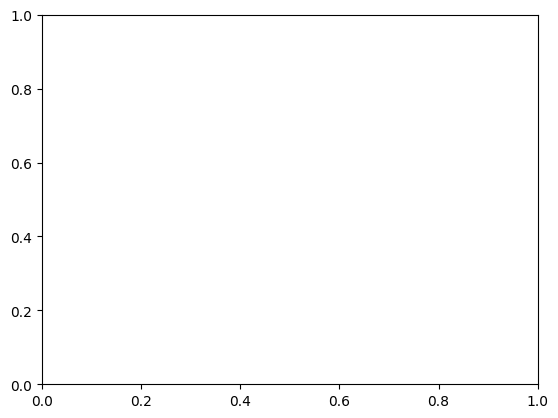

In [21]:
def probability_of_mutation(branch_length, mutation):
    site, _, _, child_idxs = mutation
    scaled_rates = branch_length * rates[:parent_len]

    codon_probs = codon_probs_of_parent_scaled_nt_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
    site_codon_probs = codon_probs[site//3]
    return site_codon_probs[child_idxs]

# make a plot of probability_of_mutation for each mutation, where branch length ranges from branch_length/2 to 2*branch_length in 100 steps
fig, ax = plt.subplots()
x_values = np.linspace(0.001, 8, 100)

for mutation in multihit_mutations:
    site, _, _, child_idxs = mutation
    probs = [probability_of_mutation(branch_length * factor, mutation) for factor in x_values]
    ax.plot(x_values, probs, label=site)

In [22]:
mmatch_2(0.1*torch.Tensor([1.1764, 1.1049]))

tensor(0.0759)

### Simulated data

In [23]:
sim_df = pd.read_csv("~/data/v0/mimic_shmoof_CNNJoiLrgShmoofSmall.10K.csv.gz", compression="gzip", index_col=0)
sim_df = prepare_pcp_df(sim_df, crepe, site_count)
sim_df["branch_length"] = optimized_branch_lengths_of_crepe(crepe, sim_df)

/Users/wdumm/opt/miniconda3/envs/epam/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Finding optimal branch lengths: 100%|██████████| 9998/9998 [03:25<00:00, 48.77it/s]


In [24]:
sim_hc_site_df = hc_site_df_of_pcp_df(sim_df, hit_class_tensors, site_count, branch_length_quantile_dict)
sim_hc_site_df

Consolidating rows: 100%|██████████| 9998/9998 [00:13<00:00, 755.14it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,22,0,0.989499,0.010470,0.000031,2.787105e-08,3.0
1,0,23,0,0.992572,0.007412,0.000017,1.183447e-08,3.0
2,0,24,0,0.993445,0.006541,0.000014,9.580348e-09,3.0
3,0,25,0,0.986348,0.013591,0.000061,8.933485e-08,3.0
4,0,26,0,0.988869,0.011091,0.000040,4.592530e-08,3.0
...,...,...,...,...,...,...,...,...
935083,9997,113,0,0.955186,0.044149,0.000662,3.221243e-06,NaN
935084,9997,114,0,0.962305,0.037261,0.000432,1.503587e-06,NaN
935085,9997,115,0,0.948583,0.050537,0.000875,4.910097e-06,NaN
935086,9997,116,0,0.973614,0.026157,0.000228,6.499541e-07,NaN


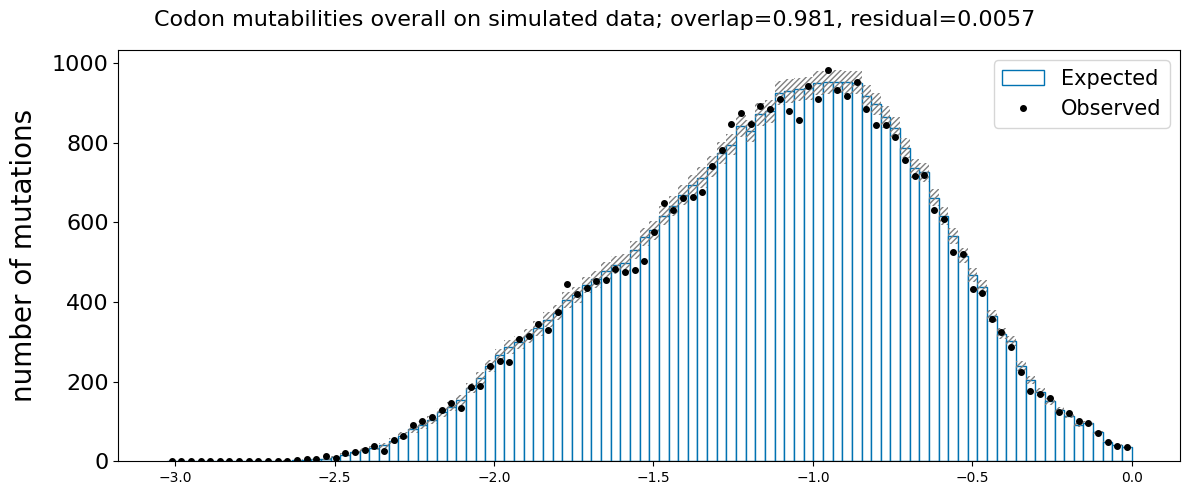

In [25]:
fig, _ = simple_codon_oe_plot(sim_hc_site_df, "Codon mutabilities overall on simulated data")